In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import layers, losses
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')


2023-10-27 15:51:34.556863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-27 15:51:34.556888: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


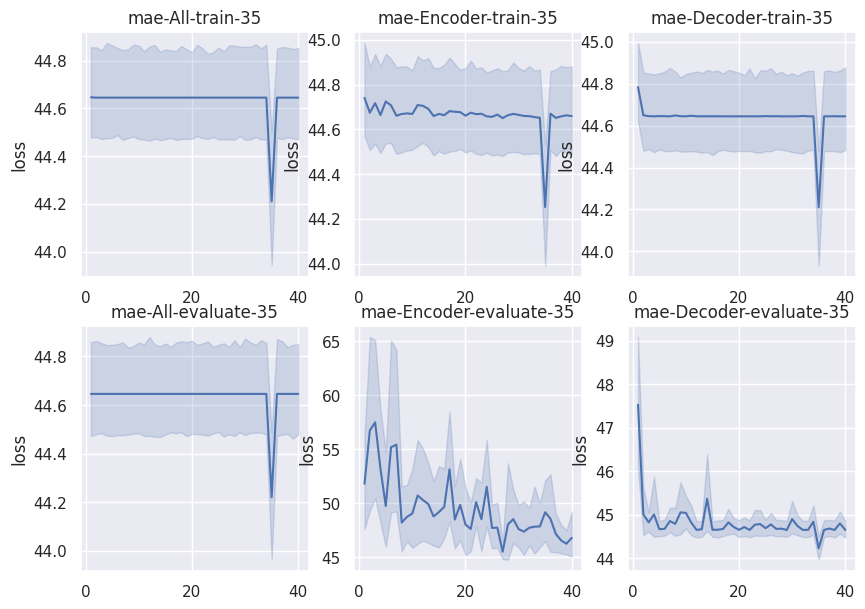

In [3]:
f, axs= plt.subplots(2, 3, figsize = (10,7))
models = ['All', 'Encoder', 'Decoder', 'All', 'Encoder', 'Decoder']
loss= 'mae'
for i, model in enumerate(models):
    train_evaluate = 'train'
    l = 0
    c = i
    if i>2:
        train_evaluate = 'evaluate'
        l = 1
        c = i-3
    data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/{train_evaluate}/loss_{loss}_{model}.csv', names = ['cid', 'round', 'loss'])
    sns.lineplot(data = data, x = 'round', y = 'loss', ax = axs[l][c])
    axs[l][c].set_title(f'{loss}-{model}-{train_evaluate}-35')
    axs[l][c].set_xlabel('')

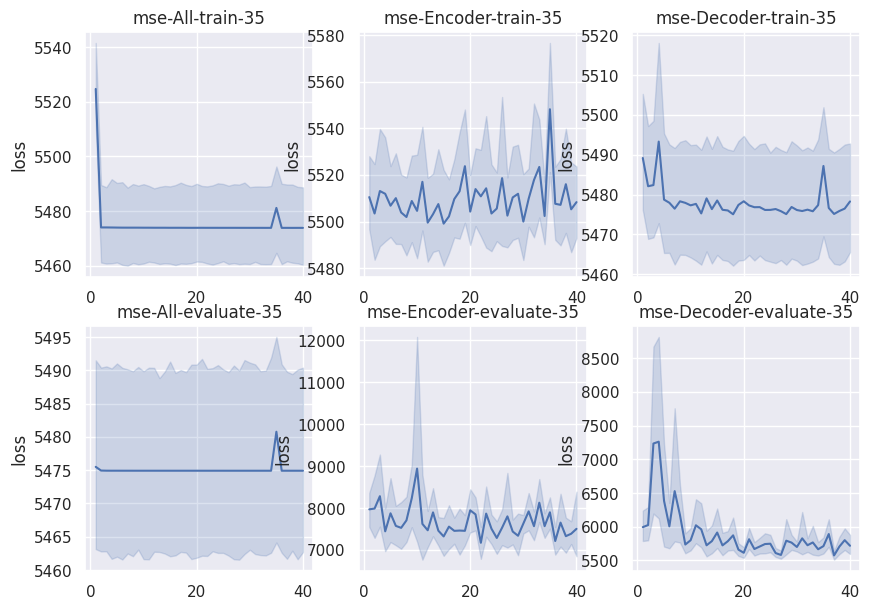

In [4]:
f, axs= plt.subplots(2, 3, figsize = (10,7))
models = ['All', 'Encoder', 'Decoder', 'All', 'Encoder', 'Decoder']
loss= 'mse'
for i, model in enumerate(models):
    train_evaluate = 'train'
    l = 0
    c = i
    if i>2:
        train_evaluate = 'evaluate'
        l = 1
        c = i-3
    data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/{train_evaluate}/loss_{loss}_{model}.csv', names = ['cid', 'round', 'loss'])
    sns.lineplot(data = data, x = 'round', y = 'loss', ax = axs[l][c])
    axs[l][c].set_title(f'{loss}-{model}-{train_evaluate}-35')
    axs[l][c].set_xlabel('')
    

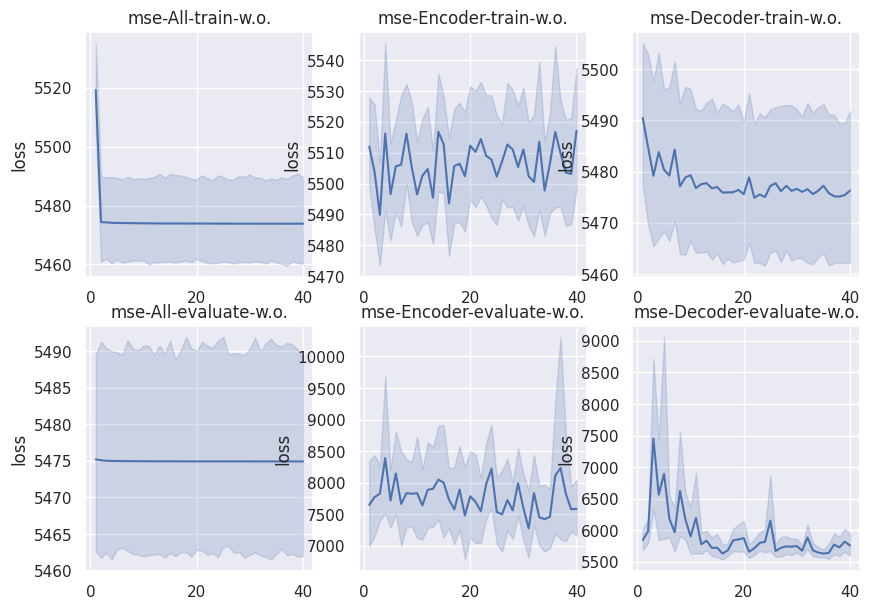

In [5]:
f, axs= plt.subplots(2, 3, figsize = (10,7))
models = ['All', 'Encoder', 'Decoder', 'All', 'Encoder', 'Decoder']
loss= 'mse'
for i, model in enumerate(models):
    train_evaluate = 'train'
    l = 0
    c = i
    if i>2:
        train_evaluate = 'evaluate'
        l = 1
        c = i-3
    data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/wo_anomaly/{train_evaluate}/loss_{loss}_{model}.csv', names = ['cid', 'round', 'loss'])
    sns.lineplot(data, x = 'round', y = 'loss', ax = axs[l][c])
    axs[l][c].set_title(f'{loss}-{model}-{train_evaluate}-w.o.')
    axs[l][c].set_xlabel('')

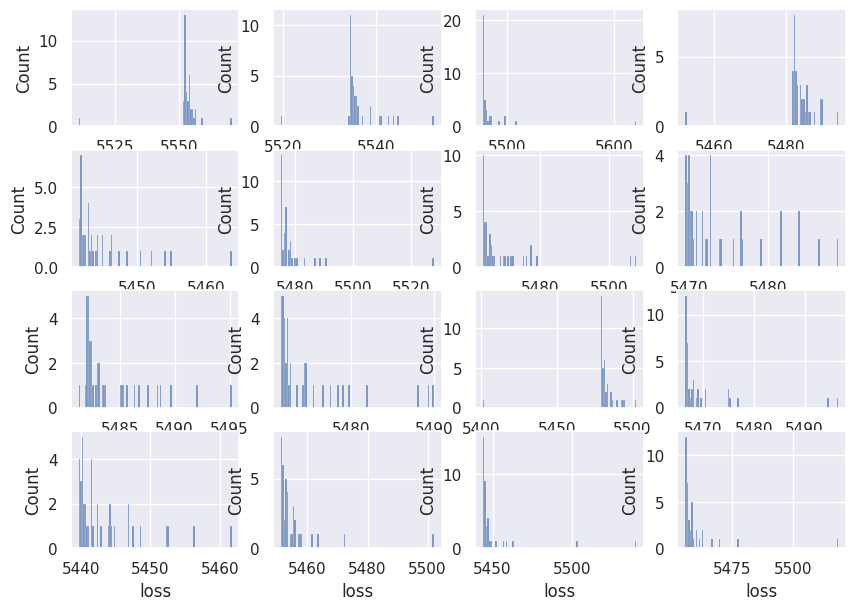

In [6]:
data = pd.read_csv('/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/train/loss_mse_Decoder.csv', names = ['cid', 'round', 'loss'])
#sns.lineplot(data = data.groupby('round').mean(), x = 'round', y = 'loss')
f, ax = plt.subplots(4, 4, figsize = (10,7))
axs = ax.flatten()

for i in range(16):
    sns.histplot(data = data[data['cid'] == i][data['round']>1], x = 'loss', bins = 100, ax = axs[i])

<AxesSubplot:xlabel='round', ylabel='loss'>

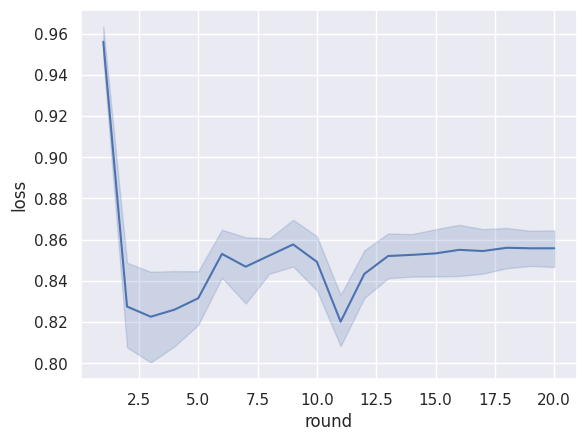

In [7]:
loss = 'mse'
model = 'Decoder'
train_evaluate = 'train'
data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/teste2/logs/SKAB/CNN/{train_evaluate}/loss_{loss}_{model}.csv', names = ['cid', 'round', 'loss','diff', 'anomaly', 'true_anomaly'])
sns.lineplot(data = data, x = 'round', y = 'loss')

In [27]:
loss = 'mse'
model = 'All'
train_evaluate = 'evaluate'
data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/teste5/logs/SKAB/CNN/{train_evaluate}/loss_{loss}_{model}.csv', names = ['cid', 'round', 'loss','diff', 'anomaly', 'true_anomaly'])
sns.lineplot(data , x = 'round', y = 'loss')#, hue='cid', alpha = 0.3)

FileNotFoundError: [Errno 2] No such file or directory: '/home/gabrieltalasso/IoT_Anomaly_Detection/teste5/logs/SKAB/CNN/train/loss_mse_All.csv'

In [9]:
accuracy_score(data['anomaly'], data['true_anomaly'])

0.9655172413793104

In [10]:
f1_score(data['anomaly'], data['true_anomaly'])

0.0

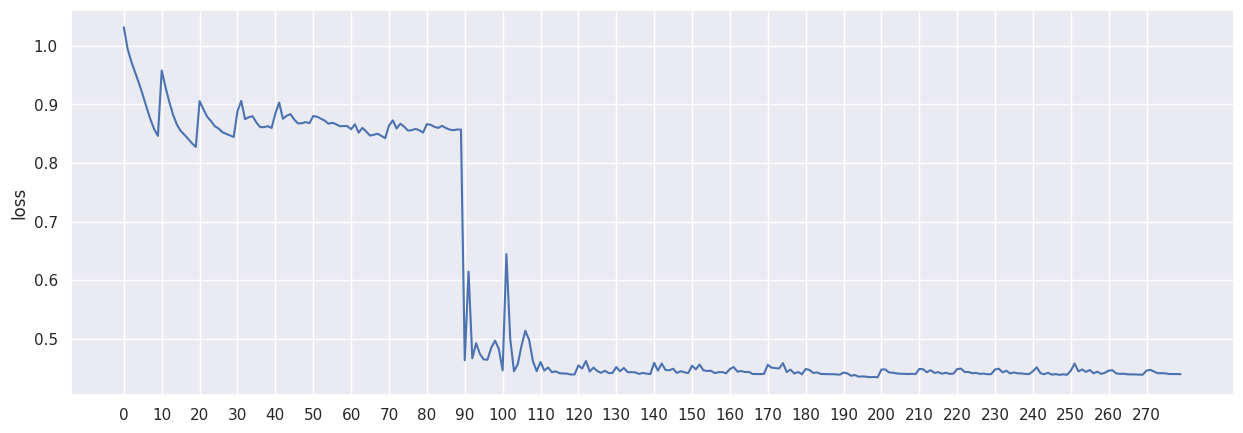

In [17]:
fig, ax = plt.subplots(figsize=(15,5))

loss = 'mse'
model = 'All'
train_evaluate = 'train'
data2 = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/teste4/logs/SKAB/CNN/{train_evaluate}/1/loss_{loss}_{model}.csv', names = ['round', 'cid',  'loss', '-', '--'])
sns.lineplot(data = data2, x = range(len(data2)), y = 'loss', ax=ax)
ax.set_xticks(list(range(len(data2)))[::10])
valores = data2['loss'].values[::10]

In [12]:
data

,cid,round,loss,diff,anomaly,true_anomaly
0,13,1,6.276188,0.000000,0,0
1,0,1,6.272248,0.000000,0,0
2,12,1,6.128126,0.000000,0,0
3,2,1,6.371402,0.000000,0,0
4,9,1,6.427894,0.000000,0,0
...,...,...,...,...,...,...
459,0,29,5.981627,5.113948,0,0
460,9,29,5.895659,5.037031,0,0
461,1,29,5.885179,5.040840,0,0
462,6,29,6.079447,5.190966,0,0


ValueError: All arrays must be of the same length

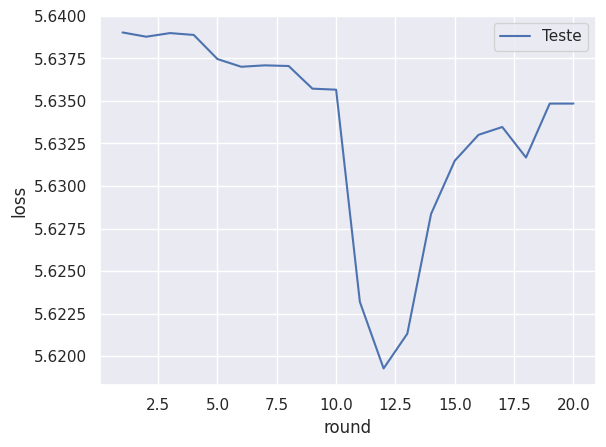

In [13]:
loss = 'mse'
model = 'Decoder'
train_evaluate = 'evaluate'
data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/teste3/logs/SKAB/CNN/{train_evaluate}/loss_{loss}_{model}.csv', names = ['cid', 'round', 'loss','diff', 'anomaly', 'true_anomaly'])
data = data[data['cid'] == 1].copy()
data = data.tail(20)
sns.lineplot(data = data, x = 'round', y = 'loss', label='Teste')
sns.lineplot(x = range(20), y = valores, label='Treino')

In [ ]:
#modelo pre treinado
#federar o anomaly free
#treinar apenas ate o round 10
#
#plotar as time series

In [ ]:
data_free.head()

,datetime;Accelerometer1RMS;Accelerometer2RMS;Current;Pressure;Temperature;Thermocouple;Voltage;Volume Flow RateRMS
0,2020-02-08 13:30:47;0.202394;0.275154;2.16975;...
1,2020-02-08 13:30:48;0.203153;0.277857;2.07999;...
2,2020-02-08 13:30:50;0.202054;0.27579;2.52577;0...
3,2020-02-08 13:30:51;0.203595;0.278101;2.49742;...
4,2020-02-08 13:30:52;0.201889;0.276363;2.29194;...


In [ ]:
data_free = pd.read_csv('data/SKAB/anomaly-free/anomaly-free.csv',  sep = ';')
data_free = data_free.drop('datetime', axis = 1)
data_free = data_free.iloc[60:65]

In [ ]:
data_free

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
60,0.203190,0.279851,2.12139,0.054711,90.9835,26.8941,231.748,121.337
61,0.203808,0.275474,2.36979,0.054711,90.8981,26.8963,223.551,121.000
62,0.203234,0.278726,1.90811,0.054711,90.9675,26.8963,229.721,121.664
63,0.203846,0.276730,1.94538,0.382638,91.1058,26.8994,227.809,122.000
64,0.204063,0.278713,2.17024,0.054711,90.9522,26.8975,236.404,121.337
